In [ ]:
import random
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
from Farm_Evaluator_Vec import getTurbLoc, loadPowerCurve, binWindResourceData, preProcessing, getAEP, checkConstraints

In [ ]:
power_curve = loadPowerCurve('power_curve.csv')
turb_rad = 50

In [ ]:
n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing(power_curve)

In [ ]:
# Years on which the data is available
year_list = ['2007','2008','2009','2013','2014','2015','2017']

wind_data_list = []
for year in year_list:
    wind_data_list.append(pd.read_csv("wind_data_{}.csv".format(year)))

In [ ]:
def gen_coord():
    x = round(random.uniform(min_lim, max_lim),2)
    y = round(random.uniform(min_lim, max_lim),2)
    return x,y

In [ ]:
def check_violation(turb1, turb2):
    return np.linalg.norm(turb1 - turb2) > 8*turb_rad

In [ ]:
def get_rectangle(perc):
    x = max_lim-min_lim
    width = (x-sqrt(x*x*(1-(perc/100))))/2
    return Polygon([(min_lim+width, min_lim+width), (min_lim+width, max_lim-width), 
                    (max_lim-width, max_lim-width), (max_lim-width, min_lim+width)])

In [ ]:
def generate_turb_locations(bound_perc):
    rect = get_rectangle(bound_perc)
    arr = []
    for i in range(turb_count):
        while True:
            new_cord = gen_coord()
            if not rect.contains(Point(new_cord)):
                if all([check_violation(np.array(cord), np.array(new_cord)) for cord in arr]):
                    arr.append(new_cord)
                    break
    return arr

In [ ]:
def calculate_AEP(turb_coords):
    aep = []
    for wind_data in wind_data_list:
        wind_inst_freq =  binWindResourceData(wind_data)
        aep.append(getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
                  n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t))
    return sum(aep)/len(aep)

In [ ]:
class TurbGroup:
    def __init__(self, boundary_area_percentage):
        self.turb_coords = np.array(generate_turb_locations(boundary_area_percentage))
        self.fitness = -1
        self.violation_count = 0
    
    def count_violation(self):
        for i,turb1 in enumerate(self.turb_coords):
            for turb2 in np.delete(self.turb_coords, i, axis=0):
                if  np.linalg.norm(turb1 - turb2) < 8*turb_rad:
                    self.violation_count += 1
                    
        
    def calculate_fitness(self):
        self.count_violation()
        fitness = calculate_AEP(self.turb_coords)
        fitness -= fitness*penalty*self.violation_count
        self.fitness = fitness


In [ ]:
def ga():

    pop = init_pop(POP_SIZE)
    pop = fitness(pop)
    
    for generation in range(GEN_COUNT):    
        
        nextgen_pop = []
        for i in range(int(POP_SIZE/2)):
            parent1 = selection(pop)
            parent2 = selection(pop)
            offspring = crossover(parent1, parent2)
            nextgen_pop.append(mutation(offspring[0]))
            nextgen_pop.append(mutation(offspring[1]))
        pop = fitness(nextgen_pop)
        best = sorted(pop, key=lambda x: x.fitness, reverse=True)
        print("Best fit in Generation no {}: {}".format(generation, best[0].fitness))
    return best[0]


In [ ]:
def init_pop(population_count):
    turb_list = []
    for i in range(population_count):
        print("Generating population no {}".format(i+1))
        turb_list.append(TurbGroup(boundary_area_percentage))
    return turb_list

In [ ]:
def fitness(population):
    for agent in population:
        agent.calculate_fitness()
    return population

In [ ]:
def selection(population):
    players = random.sample(population, TOURNAMENT_SIZE)
    sorted_players = sorted(players, key=lambda x: x.fitness, reverse=True)

    return sorted_players[0]

In [ ]:
def crossover(p1, p2):
    if random.random() < XO_PROB:
        xo_pt = random.randrange(turb_count)
        c1 = np.vstack([p1.turb_coords[:xo_pt], p2.turb_coords[xo_pt:]])
        c2 = np.vstack([p2.turb_coords[:xo_pt], p1.turb_coords[xo_pt:]])
        p1.turb_coords, p2.turb_coords = c1, c2

    return p1, p2

In [ ]:
def mutation(agent):
    if random.random() < MUT_PROB:
        return TurbGroup(100)
    else:
        return agent

In [ ]:
# Problem parameter
min_lim = 50
max_lim = 3950
turb_count = 50
penalty = 0.05

In [ ]:
# set the boundary area here
boundary_area_percentage = 65

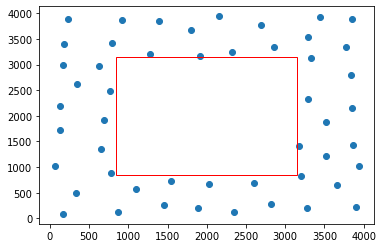

In [ ]:
# visualize the boundary here
x=max_lim-min_lim
width = (x-sqrt(x*x*(1-(boundary_area_percentage/100))))/2
t = np.array(generate_turb_locations(boundary_area_percentage))
fig, ax = plt.subplots(1)
ax.scatter(t[:,0], t[:,1])
rect = patches.Rectangle((min_lim+width,min_lim+width),x-(2*width),x-(2*width),linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

In [ ]:
# GA parameters
POP_SIZE = 5
GEN_COUNT = 2
TOURNAMENT_SIZE = 3 # should be always less than POP_SIZE
MUT_PROB = 0.15
XO_PROB = 0.75

In [ ]:
# best_fit is an instance of the class TurbGroup
# you can get the location using the attribute turb_coords
# eg: best_fit.turb_coords
best_fit = ga()

Generating population no 1
Generating population no 2
Generating population no 3
Generating population no 4
Generating population no 5


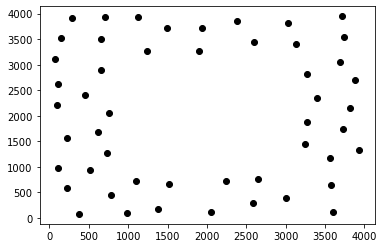

In [ ]:
plt.scatter(best_fit.turb_coords[:,0],best_fit.turb_coords[:,1], c='black')